# Simple Weighted Attention Mechanism V2

## Torch Implementation

In [1]:
import torch
from torch import nn

torch.manual_seed(789)

In [2]:
class SelfAttention_v2(nn.Module):
  def __init__(self, d_in, d_out):
    super().__init__()

    self.W_query = nn.Linear(d_in, d_out, bias=False)
    self.W_key = nn.Linear(d_in, d_out, bias=False)
    self.W_value = nn.Linear(d_in, d_out, bias=False)

  def forward(self, x):
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    attn_scores = queries @ keys.T
    attn_scores_scaled = attn_scores / (keys.shape[-1]  ** 0.5)
    attn_weights = torch.softmax(attn_scores_scaled, dim=-1)

    context_vecs = attn_weights @ values

    return context_vecs



In [3]:
# Your journey starts with one step
context = torch.tensor(
  [
    [0.43, 0.15, 0.86], # Your
    [0.55, 0.87, 0.66], # journey
    [0.57, 0.85, 0.64], # starts 
    [0.22, 0.58, 0.33], # with
    [0.77, 0.25, 0.10], # one
    [0.05, 0.80, 0.55] # step
  ]
)

context.shape

torch.Size([6, 3])

In [4]:
d_in = context[0].shape[0]
d_out = context[0].shape[0]

d_in, d_out

(3, 3)

In [5]:
sa_v2 = SelfAttention_v2(d_in, d_out)

context_vecs = sa_v2(context)
context_vecs

tensor([[ 0.4155, -0.4935,  0.0475],
        [ 0.4146, -0.4936,  0.0481],
        [ 0.4146, -0.4937,  0.0481],
        [ 0.4165, -0.4985,  0.0489],
        [ 0.4169, -0.4975,  0.0483],
        [ 0.4158, -0.4975,  0.0489]], grad_fn=<MmBackward0>)

## TTNN Implementation

In [6]:
import ttnn

device_id = 0
device = ttnn.open_device(device_id=device_id)

2025-05-18 11:01:59.362 | DEBUG    | ttnn.library_tweaks:prepare_dir_as_metal_home:54 - Existing installation of 0.57.0rc60+any detected


2025-05-18 11:01:59.389 | DEBUG    | ttnn:<module>:83 - Initial ttnn.CONFIG:
Config{cache_path=/home/avgdev/.cache/ttnn,model_cache_path=/home/avgdev/.cache/ttnn/models,tmp_dir=/tmp/ttnn,enable_model_cache=false,enable_fast_runtime_mode=true,throw_exception_on_fallback=false,enable_logging=false,enable_graph_report=false,enable_detailed_buffer_report=false,enable_detailed_tensor_report=false,enable_comparison_mode=false,comparison_mode_should_raise_exception=false,comparison_mode_pcc=0.9999,root_report_path=generated/ttnn/reports,report_name=std::nullopt,std::nullopt}


                 Device | INFO     | Opening user mode device driver
2025-05-18 11:01:59.436 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled

2025-05-18 11:01:59.444 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-05-18 11:01:59.445 | INFO     | SiliconDriver   - Harvesting mask for chip 0 is 0x200 (physical layout: 0x1, logical: 0x200, simulated harvesting mask: 0x0).
2025-05-18 11:01:59.446 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-05-18 11:01:59.446 | INFO     | SiliconDriver   - Detected PCI devices: [0]
2025-05-18 11:01:59.446 | INFO     | SiliconDriver   - Using local chip ids: {0} and remote chip ids {}
2025-05-18 11:01:59.455 | INFO     | SiliconDriver   - Software version 6.0.0, Ethernet FW version 6.14.0 (Device 0)
                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | 

New chip! We now have 1 chips
Chip initialization complete (found )
Chip initializing complete...
 ARC

 [4/4] DRAM

 [16/16] ETH

 CPU

Chip detection complete (found )


The goal of porting over our `torch` `SelfAttention_v2` class is to port the implementation over line-by-line to `ttnn`.

Let's consider this line here:
```python
attn_scores = queries @ keys.T
```

Porting to `ttnn` would involve -- in the naive way:
1. `torch` - Assign `queries` to be the result of the linear transformation with `W_query`. `queries = W_query(x)`
2. `torch` - Transpose the `keys` (result of linear transformation with `W_key` and `x`) - we'll call this `keys_transposed`
3. `ttnn` - Create the `ttnn` tensors from `queries` and `keys_transposed` - get back `queries_ttnn` and `keys_transposed_ttnn`
4. `ttnn` - Compute the multiplication of the tensors using `ttnn.matmul` (`queries_ttnn` and `keys_transposed_ttnn`) -- since there is no bias, we don't have to worry about this.


In [7]:
# torch operations (steps 1 and 2)
queries = sa_v2.W_query(context)
keys = sa_v2.W_key(context)
keys_transposed = keys.T

# ttnn operations (steps 3)
queries_ttnn = ttnn.from_torch(
  queries,
  dtype=ttnn.bfloat16,
  layout=ttnn.TILE_LAYOUT,
  device=device
)
keys_transposed_ttnn = ttnn.from_torch(
  keys_transposed,
  dtype=ttnn.bfloat16,
  layout=ttnn.TILE_LAYOUT,
  device=device
)

# ttnn.matmul to find the attention scores
attn_scores_ttnn = ttnn.matmul(
  queries_ttnn,
  keys_transposed_ttnn
)

# compute the torch version too for comparison
attn_scores_torch = queries @ keys.T

attn_scores_ttnn, attn_scores_torch

                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 4,5. First unused index: 2. Kernels: reader_bmm_tile_layout_in1_sender_writer_padding, reader_bmm_tile_layout_in0_sender_padding, bmm_large_block_zm_fused_bias_activation


(ttnn.Tensor([[-0.22168, -0.23926,  ...,  0.11182, -0.31250],
              [-0.31641, -0.35547,  ..., -0.02905, -0.33594],
              ...,
              [-0.13184, -0.13965,  ...,  0.06641, -0.18164],
              [-0.23730, -0.27539,  ..., -0.09424, -0.21484]], shape=Shape([6, 6]), dtype=DataType::BFLOAT16, layout=Layout::TILE),
 tensor([[-0.2219, -0.2409, -0.2256, -0.1580,  0.1130, -0.3137],
         [-0.3159, -0.3568, -0.3446, -0.2067, -0.0292, -0.3369],
         [-0.3108, -0.3506, -0.3384, -0.2037, -0.0245, -0.3337],
         [-0.1767, -0.2026, -0.1975, -0.1128, -0.0502, -0.1695],
         [-0.1322, -0.1401, -0.1312, -0.0915,  0.0668, -0.1827],
         [-0.2371, -0.2754, -0.2699, -0.1499, -0.0948, -0.2134]],
        grad_fn=<MmBackward0>))

Now, the operation that we are trying to translate from `torch` to `ttnn` will be:

```python
attn_scores_scaled = attn_scores / (keys.shape[-1] ** 0.5)
attn_weights = torch.softmax(attn_scores_scaled, dim=-1)
context_vecs = attn_weights @ values
```

1. First get the scaled version of `attn_scores_scaled` in `ttnn`. That is using maybe the `ttnn.div` -- call the result `attn_scores_scaled_ttnn`.
2. Then perform a `ttnn.softmax` of `attn_scores_scaled_ttnn`. -- call the result `attn_weights_ttnn`.
3. Get `values_ttnn` by performing the transformation of `W_value` and `x` and converting that to a `ttnn.tensor`.
4. Compute the `context_vecs_ttnn` by calling `ttnn.matmul` on `attn_weights_ttnn` and `values_ttnn`.


In [8]:
attn_scores_scaled_ttnn = ttnn.div(
  attn_scores_ttnn,
  (keys.shape[-1] ** 0.5)
)
attn_weights_ttnn = ttnn.softmax(
  attn_scores_scaled_ttnn,
  dim=-1
)

values = sa_v2.W_value(context)
values_ttnn = ttnn.from_torch(
  values,
  dtype=ttnn.bfloat16,
  layout=ttnn.TILE_LAYOUT,
  device=device
)

context_vecs_ttnn = ttnn.matmul(attn_weights_ttnn, values_ttnn)

# compute the torch version for comparison
context_vecs = (
  torch.softmax(
    attn_scores_torch / (keys.shape[-1] ** 0.5),
    dim=-1
  )
) @ sa_v2.W_value(context)

context_vecs_ttnn, context_vecs

                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 2. First unused index: 1. Kernels: reader_unary_interleaved_start_id
                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 2. First unused index: 1. Kernels: writer_unary_interleaved_start_id, reader_unary_interleaved_start_id, eltwise_sfpu
                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 2,5,6,7,11. First unused index: 1. Kernels: writer_unary_interleaved_start_id_blocked_sm, reader_unary_interleaved_sm, softmax


(ttnn.Tensor([[ 0.41406, -0.49219,  0.04761],
              [ 0.41211, -0.49219,  0.04810],
              ...,
              [ 0.41602, -0.49609,  0.04834],
              [ 0.41211, -0.49414,  0.04834]], shape=Shape([6, 3]), dtype=DataType::BFLOAT16, layout=Layout::TILE),
 tensor([[ 0.4155, -0.4935,  0.0475],
         [ 0.4146, -0.4936,  0.0481],
         [ 0.4146, -0.4937,  0.0481],
         [ 0.4165, -0.4985,  0.0489],
         [ 0.4169, -0.4975,  0.0483],
         [ 0.4158, -0.4975,  0.0489]], grad_fn=<MmBackward0>))

In [9]:
ttnn.close_device(device)


                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0


## SelfAttention_ttnn_v2 Implementation (naive way)

This is still going to be a `torch` module. It is just that now, when we do a forward pass, we will be using our accelerator. (Wormhole n150d)

In [10]:
class SelfAttention_ttnn_v2(nn.Module):
  def __init__(self, d_in, d_out, device):
    super().__init__()

    self.W_query = nn.Linear(d_in, d_out, bias=False)
    self.W_key = nn.Linear(d_in, d_out, bias=False)
    self.W_value = nn.Linear(d_in, d_out, bias=False)

    self.device = device

  def forward(self, x):
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    queries_ttnn = ttnn.from_torch(
      queries,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device
    )
    values_ttnn = ttnn.from_torch(
      values,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device
    )
    keys_ttnn = ttnn.from_torch(
      keys,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device
    )
    keys_transposed_ttnn = ttnn.permute(keys_ttnn, (1, 0))

    attn_scores_ttnn = ttnn.matmul(
      queries_ttnn,
      keys_transposed_ttnn
    )
    attn_scores_scaled_ttnn = ttnn.div(
      attn_scores_ttnn,
      (keys_ttnn.shape[-1] ** 0.5)
    )

    attn_weights_ttnn = ttnn.softmax(attn_scores_scaled_ttnn, dim=-1)

    context_vecs_ttnn = ttnn.matmul(attn_weights_ttnn, values_ttnn)

    context_vecs = ttnn.to_torch(context_vecs_ttnn)

    return context_vecs

In [11]:
torch.manual_seed(789)

device_id = 0
device = ttnn.open_device(device_id=device_id)

sa_ttnn_v2 = SelfAttention_ttnn_v2(d_in, d_out, device)
context_vecs = sa_ttnn_v2(context)

ttnn.close_device(device)

context_vecs

                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz
                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 16. First unused index: 1. Kernels: reader_unary_transpose_wh_interleaved_start_id
                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 16. First unused index: 1. Kernels: writer_unary_interleaved_start_id, reader_unary_transpose_wh_interleaved_start_id, transpose_wh
                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0


TorchTensor([[ 0.4141, -0.4922,  0.0476],
             [ 0.4121, -0.4922,  0.0481],
             [ 0.4141, -0.4922,  0.0481],
             [ 0.4141, -0.4961,  0.0486],
             [ 0.4160, -0.4961,  0.0483],
             [ 0.4121, -0.4941,  0.0483]], dtype=torch.bfloat16)

## Benchmarking

In [12]:
import time

start = time.time()

print("do something")

end = time.time()

print(f"Time: {(end - start) * 1000} milliseconds")

do something
Time: 0.1919269561767578 milliseconds


## PerfTimer Implementation

In [13]:
import time

class PerfTimer:
  def __init__(self):
    self.start_time = 0
    self.end_time = 0

  def start(self):
    self.start_time = time.time()

  def stop(self):
    self.end_time = time.time()

  def reset(self):
    self.start_time = 0 
    self.end_time = 0

  def elapsed_ms(self):
    return (self.end_time - self.start_time) * 1000

In [14]:
torch.manual_seed(789)

timer = PerfTimer()

timer.start()
torch_tensors = torch.stack([torch.randn(1024, 2048) for _ in range(0, 1000)])
timer.stop()

torch_tensors, torch_tensors.shape, timer.elapsed_ms()

(tensor([[[-4.8013e-01, -8.4702e-01, -3.7162e-01,  ..., -4.2555e-01,
            9.3356e-01, -3.1994e-01],
          [ 3.3288e-01, -8.0071e-01,  1.2809e+00,  ..., -3.9552e-01,
           -1.0113e+00,  2.8377e-02],
          [-3.2341e-01,  7.0033e-01, -1.3483e+00,  ...,  6.5519e-01,
           -1.1647e-03, -1.5051e-01],
          ...,
          [ 4.8435e-01, -1.3057e+00, -6.1837e-01,  ..., -8.0291e-01,
            7.2481e-01, -1.0800e+00],
          [ 1.6447e+00, -9.2544e-01,  1.9768e-01,  ...,  2.4887e-01,
            8.5295e-01,  2.5563e+00],
          [-1.5383e+00,  2.5991e-01,  3.0148e-01,  ...,  5.2626e-01,
           -1.5371e-02,  4.7171e-01]],
 
         [[-1.1993e+00,  1.2636e+00, -8.1220e-01,  ..., -1.0694e+00,
           -8.3148e-02,  1.2506e+00],
          [ 8.3910e-01,  5.4396e-01, -3.2130e-02,  ...,  2.6796e-02,
            1.5036e+00, -1.6100e-01],
          [-3.5643e-01, -1.5594e-01, -3.7622e-01,  ..., -3.5300e-01,
            3.0946e-01,  7.7755e-01],
          ...,
    

## SelfAttention_v2 on CPU!

Start power consumption: 138 W

During benchmark: 223 W

Delta: 85W

In [29]:
timer.reset()

timer.start()
sa_v2 = SelfAttention_v2(2048, 2048)
for tensor in torch_tensors:
  result = sa_v2(tensor)
timer.stop()

result, timer.elapsed_ms()

(tensor([[-0.0036,  0.0017, -0.0037,  ..., -0.0043,  0.0384, -0.0250],
         [-0.0086,  0.0101, -0.0003,  ..., -0.0247,  0.0419, -0.0155],
         [-0.0135,  0.0110,  0.0039,  ..., -0.0118,  0.0421, -0.0184],
         ...,
         [-0.0096,  0.0183, -0.0006,  ..., -0.0108,  0.0271, -0.0035],
         [-0.0272,  0.0066, -0.0028,  ..., -0.0029,  0.0252, -0.0051],
         [-0.0112,  0.0099,  0.0088,  ..., -0.0091,  0.0400, -0.0190]],
        grad_fn=<MmBackward0>),
 56910.855293273926)

## SelfAttention_v2 on TTNN! (naive)

In [27]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz


In [29]:
timer.reset()

timer.start()
sa_ttnn_v2 = SelfAttention_ttnn_v2(2048, 2048, device)
for tensor in torch_tensors:
  result = sa_ttnn_v2(tensor)
timer.stop()

result, timer.elapsed_ms()

(TorchTensor([[ 0.0082, -0.0031, -0.0339,  ...,  0.0028, -0.0325, -0.0008],
              [ 0.0098,  0.0149, -0.0386,  ...,  0.0262, -0.0243,  0.0126],
              [ 0.0058,  0.0100, -0.0364,  ...,  0.0308, -0.0303,  0.0040],
              ...,
              [-0.0140,  0.0063, -0.0513,  ...,  0.0222, -0.0427,  0.0064],
              [ 0.0044, -0.0039, -0.0277,  ...,  0.0074, -0.0302,  0.0047],
              [ 0.0117,  0.0048, -0.0332,  ...,  0.0093, -0.0347,  0.0126]],
             dtype=torch.bfloat16),
 69427.5848865509)

In [ ]:
ttnn.close_device(device)

## Optimized SelfAttention_ttnn_v2

### Memory Config

2025-05-18 10:38:26.457 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz
                 Always | INFO     | Begin op: tt::tt_metal::detail::convert_python_tensor_to_tt_tensor
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<pybind11::handle const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Layout>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Tile> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | input any type name ignored: std::__1:

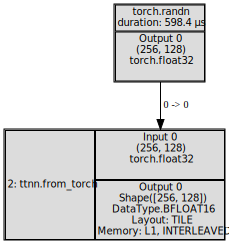

In [2]:
import os
os.environ["TTNN_CONFIG_OVERRIDES"] = "{\"enable_fast_runtime_mode\": false}" 

import ttnn
import torch
from ttnn.tracer import trace, visualize

device_id = 0
device = ttnn.open_device(device_id=device_id)

with trace():
  test_ttnn = ttnn.from_torch(
    torch.randn(256, 128),
    dtype=ttnn.bfloat16,
    layout=ttnn.TILE_LAYOUT,
    device=device,
    memory_config=ttnn.L1_MEMORY_CONFIG
  )

visualize(test_ttnn)


In [3]:

ttnn.close_device(device)


                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0


Start power consumption: 139 W

During power consumption: 215 W

Delta = 76 W

In [26]:
class SelfAttention_ttnn_optimized_v2(nn.Module):
  def __init__(self, d_in, d_out, device):
    super().__init__()

    self.W_query = nn.Linear(d_in, d_out, bias=False)
    self.W_key = nn.Linear(d_in, d_out, bias=False)
    self.W_value = nn.Linear(d_in, d_out, bias=False)

    self.device = device

    self.W_query_ttnn = ttnn.from_torch(
      self.W_query.weight,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device,
      memory_config=ttnn.L1_MEMORY_CONFIG
    )
    self.W_key_ttnn = ttnn.from_torch(
      self.W_key.weight,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device,
      memory_config=ttnn.L1_MEMORY_CONFIG
    )
    self.W_value_ttnn = ttnn.from_torch(
      self.W_value.weight,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device,
      memory_config=ttnn.L1_MEMORY_CONFIG
    )

    self.scalar = 1 / (d_out ** 0.5)

  def forward(self, x):
    x_ttnn = ttnn.from_torch(
      x,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device,
    )

    queries_ttnn = ttnn.linear(
      x_ttnn,
      self.W_query_ttnn,
      transpose_b=True,
      core_grid=ttnn.CoreGrid(y=8, x=8),
    )
    values_ttnn = ttnn.linear(
      x_ttnn,
      self.W_value_ttnn,
      transpose_b=True,
      core_grid=ttnn.CoreGrid(y=8, x=8),
    )
    keys_ttnn = ttnn.linear(
      x_ttnn,
      self.W_key_ttnn,
      transpose_b=True,
      core_grid=ttnn.CoreGrid(y=8, x=8),
    )

    attn_scores_ttnn = ttnn.matmul(
      queries_ttnn,
      ttnn.permute(keys_ttnn, (1, 0)),
      core_grid=ttnn.CoreGrid(y=8, x=8),
    )
    attn_scores_scaled_ttnn = attn_scores_ttnn * self.scalar
    attn_weights_ttnn = ttnn.softmax(attn_scores_scaled_ttnn, dim=-1)

    context_vecs_ttnn = ttnn.matmul(
      attn_weights_ttnn,
      values_ttnn,
      core_grid=ttnn.CoreGrid(y=8, x=8),
    )

    context_vecs = ttnn.to_torch(context_vecs_ttnn)

    return context_vecs


In [20]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

ttnn.enable_program_cache(device)

                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz
                  Metal | INFO     | Enabling program cache on device 0


In [31]:
torch.manual_seed(789)

timer.reset()

timer.start()
sa_ttnn_opt_v2 = SelfAttention_ttnn_optimized_v2(2048, 2048, device)
for tensor in torch_tensors:
  result = sa_ttnn_opt_v2(tensor)
timer.stop()

result, timer.elapsed_ms()

(TorchTensor([[ 1.4648e-02, -1.2085e-02, -1.7334e-02,  ...,  3.0640e-02,
               -2.6855e-02,  3.4180e-02],
              [ 1.4038e-02, -3.4027e-03, -2.9053e-02,  ...,  2.6001e-02,
               -2.8442e-02,  2.3560e-02],
              [ 4.0588e-03, -1.1108e-02, -3.2471e-02,  ...,  2.5146e-02,
               -2.5635e-02,  2.3804e-02],
              ...,
              [ 1.9775e-02,  1.9073e-06, -1.9653e-02,  ...,  2.4170e-02,
               -3.3447e-02,  1.7944e-02],
              [ 1.5564e-02,  4.6692e-03, -2.3071e-02,  ...,  2.1484e-02,
               -3.3936e-02,  5.1270e-03],
              [ 1.2451e-02, -7.4768e-03, -3.1006e-02,  ...,  6.6528e-03,
               -3.0518e-02,  1.1902e-02]], dtype=torch.bfloat16),
 8518.006086349487)

In [19]:
ttnn.close_device(device)

                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0
